<h2 id="Contents">Contents<a href="#Contents"></a></h2>
        <ol>
        <li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Interpolation">Interpolation</a></li>
<ol><li><a class="" href="#Taylor-series">Taylor series</a></li>
<li><a class="" href="#Lagrange-Interpolation">Lagrange Interpolation</a></li>
<ol><li><a class="" href="#Implementation">Implementation</a></li>
<li><a class="" href="#Newton’s-Forward-Interpolation">Newton’s Forward Interpolation</a></li>
</ol><li><a class="" href="#Newton-Interpolation">Newton Interpolation</a></li>
<ol><li><a class="" href="#Newton’s-Backward-Interpolation">Newton’s Backward Interpolation</a></li>
<li><a class="" href="#Implementation">Implementation</a></li>
</ol><li><a class="" href="#Spline-Interpolation">Spline Interpolation</a></li>
<ol><li><a class="" href="#scipy's-Implementation">scipy's Implementation</a></li>
</ol>

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.special import factorial

# Interpolation

* Interpolation produces a function that matches the given data exactly.
* The function then can be utilized to approximate the data values at
intermediate points.

## Taylor series

Taylor series provides a way to approximate the value of a function at a point using a finite number of terms. The theorem states that any smooth function can be approximated as a
polynomial.
$$
f(x_{i+1}) = f(x_i)+f'(x_i)h+f''(x_i)\frac{h^2}{2!}+f'''(x_i)\frac{h^3}{3!}+\ldots+f^{(n)}(x_i)\frac{h^{(n)}}{(n!)}
$$

For example, the following function is defined:
$$
f(x) = \frac{1}{1+25x^2}
$$
We'll also use the function:
$$
g(x) = \sin(x)
$$

In [5]:
plt.rcdefaults()

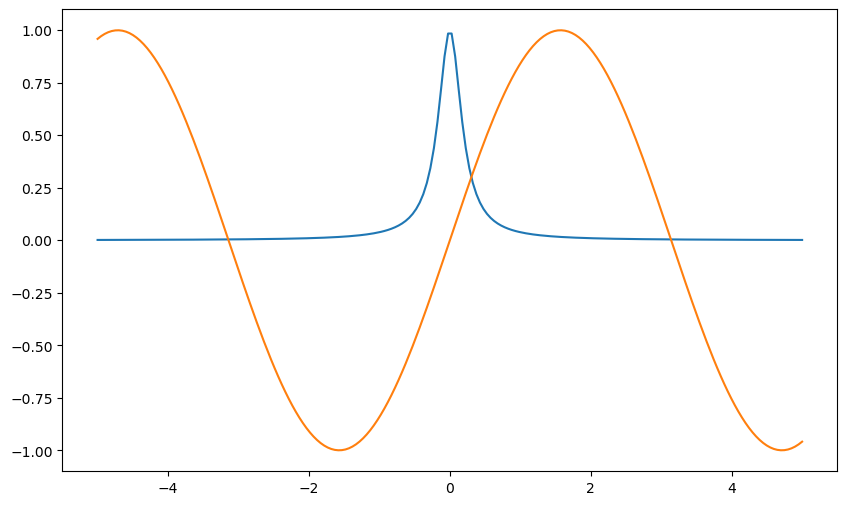

In [20]:
f = lambda x: 1/(1+25*x**2)
g = lambda x: np.sin(x)
X = np.linspace(-5, 5, 200)
y1 = f(X)
y2 = g(X)
plt.figure(figsize=(10, 6))
plt.plot(X, y1)
plt.plot(X, y2);

In [7]:
X_test_points = np.arange(-5, 6, 1)
print(X_test_points)
Y_test_points_1 = f(X_test_points)
Y_test_points_2 = g(X_test_points)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]


In [12]:
def error(x, y_pred, func=f):
    y_true = func(x)
    ae = np.abs(y_true - y_pred)
    re = np.abs(y_true - y_pred)/np.abs(y_true)
    print("Absolute error:", ae)
    print("Relative error:", re)


In [78]:
def taylor(f, x0,y0, x, n=3, h=1e-6):
    """
    Compute the nth order Taylor series approximation of f(x)
    """
    fval = y0
    for k in range(1, n+1):
        if k%2 == 0:
            order = k+1
        else:
            order = k+2
        fval += derivative(f, x0, dx=h, n=k, order=order) *(x-x0)**k/factorial(k)
    return fval
taylor(f, 0, 1, 2, n=3)

-99.0000082740371

## Lagrange Interpolation

With n points, lagrange interpolation is a polynomial approximation of the function f(x) using the following formula:
$$
P(x) = L_1(x)y_1+L_2(x)y_2+\ldots+L_n(x) y_n
$$
where 
$$
L_k(x) = \frac{N_k(x)}{D_k(x)}\\
\text{with}\\
N_k(x) = (x-x_1)(x-x_2)\cdots(x-x_{k-1})(x-x_{k+1})\cdots(x-x_n)\\
D_k(x) = (x_k-x_1)(x_k-x_2)\cdots(x-x_{k-1})(x-x_{k+1})\cdots(x_k-x_n)
$$

### Implementation

In [79]:
def euler(X,Y, x, report_error = True, **kwargs):
    n = len(X)
    Ls = np.zeros(n)
    for i in range(n):
        X_temp = np.delete(X, i)
        nkx = (x-X_temp).prod()
        dkx = (X[i]-X_temp).prod()
        Ls[i] = nkx/dkx
    result = np.dot(Ls, Y)
    if report_error:
        error(x, result, **kwargs)
    return np.dot(Ls, Y)

In [80]:
euler(X_test_points, Y_test_points_1, -2.2, func=f)

Absolute error: 0.1962737769053482
Relative error: 23.945400782452484


0.20447049821682362

In [81]:
euler(X_test_points, Y_test_points_2, 2.2, func=g)

Absolute error: 0.00011295486767493035
Relative error: 0.0001397097960378008


0.8083834489519152

## Newton Interpolation

### Newton’s Forward Interpolation

Newton interpolation assume a complete polynomial starts from lower degree
to higher degree. For n-points, Newton interpolation is a polynomial
$$
P(x) = a_1+a_2(x-x_1)+a_3(x-x_1)(x-x_2)+a_n(x-x_1)(x-x_2)(x-x_3)+\cdots+(x-x_1)\ldots(x-x_{n-1})
$$

To get the coeffcients, we see that $y = a_0, y_1 = a_0 + a_1(x_1-x_0), y_2 =  a_0 + a_1(x_2-x_0)+a_2(x_2-x_0)(x_2-x_1)$ and so on. From this, we can show that the following farmula holds for the coefficients:
$$
a_0 = y_0\\
a_1 = \frac{1}{h}\Delta y_0\\
a_2 = \frac{1}{2!h^2}\Delta^2 y_0\\
\vdots\\
a_n = \frac{1}{n!h^n}\Delta^n y_0
$$

Wiht $\Delta y_0 = y_1-y_0, \Delta^2y_0 = (y_2-y_1)-\Delta y_0 = \Delta y_1-\Delta y_0 , \Delta^3 y_0 = \Delta y_2-\Delta y_0$ and so on.

If we want to calculate the y value of $x=x_0+ph$, we can do this by:
$$
y_p = y_0+p\Delta y_0 + \frac{p(p-1)}{2!}\Delta^2 y_0 + \frac{p(p-1)(p-2)}{3!}\Delta^3 y_0 + \cdots + \frac{p(p-1)\cdots(p-(n-1))}{n!}\Delta^n y_0
$$

### Newton’s Backward Interpolation

For this case, we get:
$$
y_p = y_n+p\Delta y_n+ \frac{p(p+1)}{2!}\Delta^2 y_n + \frac{p(p+1)(p+2)}{3!}\Delta^3 y_0 + \cdots 
$$

### Implementation

In [3]:
Y = np.array([10.63, 13.03, 15.04, 16.81, 18.42, 19.90, 21.27])
y0= Y[0]
deltas = np.zeros(len(Y)+1)
deltas[0] = y0
for i in range(1, len(Y)+1):
    deltas[i] = Y[i-1]-deltas[i-1]
deltas

array([10.63,  0.  , 13.03,  2.01, 14.8 ,  3.62, 16.28,  4.99])

In [ ]:
def newton_forward(X,Y, x, h=1e-3, report_error = True, **kwargs):
    y0 = Y[0]
    p = (x-X[0])/h
    deltas = np.zeros(len(X)+1)
    deltas[0] = y0
    for i in range(1, len(X)+1):
        deltas[i] = Y[i-1]-deltas[i-1]

## Spline Interpolation

### `scipy`'s Implementation

Instead of creating the spline interpolation from scratch, we can use `scipy`'s implementation, `scipy.interpolate.interp2d`.

The class accepts the following arguments:
`x`: x-coordinates of the data points

`y`: y-coordinates of the data points

`kind`: Specifies the kind of interpolation as a string or as an integer specifying the order of the spline interpolator to use. The string has to be one of ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’. ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; ‘previous’ and ‘next’ simply return the previous or next value of the point; ‘nearest-up’ and ‘nearest’ differ when interpolating half-integers (e.g. 0.5, 1.5) in that ‘nearest-up’ rounds up and ‘nearest’ rounds down. Default is ‘linear’.

`fill_value`: The value used to fill in for requested points outside of the data range. If a two-element tuple, then the first element is used as a fill value for `x_new < x[0]` and the second element is used for `x_new > x[-1]`. For this to work, the argument `bounds_error` must be set to `False`. The `fill_value` also takes "extrapolate" as a keyword. In this case the points outside the data range will be extrapolated.

This class returns a function whose call method uses interpolation to find the value of new points.

In [8]:
from scipy.interpolate import interp1d

In [15]:
interpol = interp1d(X_test_points, Y_test_points_1, kind='linear')

In [16]:
x = 2.2
error(x, interpol(x), func=f)

Absolute error: 0.0006090265199449017
Relative error: 0.07430123543327802


In [17]:
x = 2.2
error(x, interpol(x), func=g)

Absolute error: 0.7996906559881698
Relative error: 0.9891084885599748


In [33]:
X = np.linspace(-5, 5, 10)
y1 = f(X)
y2 = g(X)
linear_inter = interp1d(X, y2, kind='linear')
linear_Y = linear_inter(X)
slinear_inter = interp1d(X, y2, kind='slinear')
slinear_Y = slinear_inter(X)
quadratic_inter = interp1d(X, y2, kind='quadratic')
quadratic_Y = quadratic_inter(X)
cubic_inter = interp1d(X, y2, kind='cubic')
cubic_Y = cubic_inter(X)

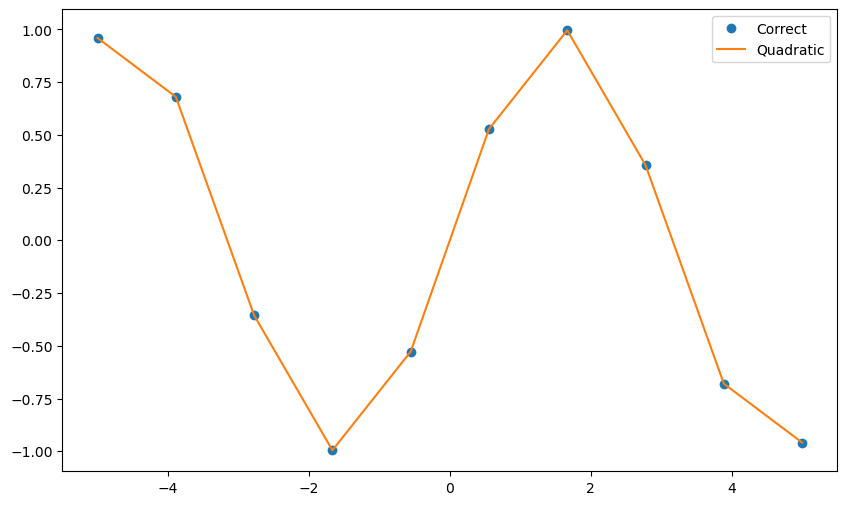

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(X, y2, "o", label="Correct")
# plt.plot(X, linear_Y, label="Linear")
# plt.plot(X, slinear_Y, label="S-Linear")
plt.plot(X, quadratic_Y, label="Quadratic")
# plt.plot(X, cubic_Y, label="Cubic")
plt.legend()
plt.show()

In [35]:
linear_Y

array([ 0.95892427,  0.67965796, -0.35584199, -0.99540796, -0.52741539,
        0.52741539,  0.99540796,  0.35584199, -0.67965796, -0.95892427])

In [36]:
slinear_Y

array([ 0.95892427,  0.67965796, -0.35584199, -0.99540796, -0.52741539,
        0.52741539,  0.99540796,  0.35584199, -0.67965796, -0.95892427])

In [37]:
np.isclose(linear_Y, y2, atol=1e-3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [38]:
quadratic_inter = interp1d(X, y2, kind='quadratic')
quadratic_Y = quadratic_inter(X)

In [39]:
quadratic_Y

array([ 0.95892427,  0.67965796, -0.35584199, -0.99540796, -0.52741539,
        0.52741539,  0.99540796,  0.35584199, -0.67965796, -0.95892427])

In [42]:
quadratic_inter.axis

0